<a href="https://colab.research.google.com/github/2019ht12169/Thesis/blob/main/naiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

import seaborn as sns

# Load the data files from drive
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


In [8]:
train_base_df = pd.read_csv('/content/gdrive/MyDrive/projects/data/dataFile_latest_train.csv') 
test_base_df = pd.read_csv('/content/gdrive/MyDrive/projects/data/dataFile_latest_test.csv') 

# Print a Summary of the Train Data
# Sentiment Classes are labeled either "negative" or "positive"
train_base_df

,label,review_date,text
0,1,2015-01-03,with all the negative reviews i was hesitant t...
1,1,2013-01-31,nice size radio and sounds good great little r...
2,1,2014-08-30,good purchase nice compact speaker works great...
3,1,2007-08-31,working nice since two years i have been using...
4,1,2014-10-31,as advertised. no complaints. as advertised. n...
...,...,...,...
1240171,0,2000-01-23,you get what you pay for the headphones look n...
1240172,0,2000-01-23,terrible quality i bought this microphone thin...
1240173,0,2000-01-21,it depends on how you use them. i purchased th...
1240174,0,2000-01-21,good thing i got if free (buy a minidisc recor...


In [11]:

# Replace the Classes with Integer Values
train_df = train_base_df.copy()
train_df["label"] = train_df["label"].astype('str')
train_df["label"] = train_df["label"].replace({"0":"negative"})
train_df["label"] = train_df["label"].replace({"1":"positive"})

# Clean the Test Data
test_df = test_base_df.copy()
test_df["label"] = test_df["label"].astype('str')
test_df["label"] = test_df["label"].replace({"0":"negative"})
test_df["label"] = test_df["label"].replace({"1":"positive"})

# Create a Feature based on Text Length
train_df['text_length'] = train_df['text'].str.len() # Store string length of each sample
train_df = train_df.sort_values(['text_length'], ascending=True)
train_df = train_df.dropna()
test_df = test_df.dropna()
train_df.head(10)

,label,review_date,text,text_length
371430,positive,2014-12-04,a a,3.0
651275,negative,2015-07-13,a a,3.0
788915,negative,2014-12-04,a a,3.0
789027,negative,2014-12-04,a a,3.0
103726,positive,2014-12-04,a a,3.0
414895,positive,2015-04-20,a ok,4.0
439790,positive,2013-04-03,best,4.0
444091,positive,2014-12-11,ok ok,5.0
530632,positive,2015-04-09,ok ok,5.0
844115,negative,2014-08-11,ok ok,5.0


Text(0, 0.5, 'Labels')

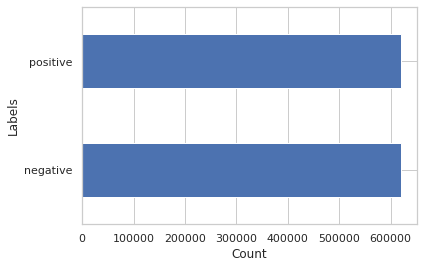

In [12]:
# Print the Distribution of Sentiment Labels
sns.set_theme(style="whitegrid")
ax = train_df['label'].value_counts(sort=False).plot(kind='barh', color='b')
ax.set_xlabel('Count')
ax.set_ylabel('Labels')

Text(0.5, 1.0, 'Text Length Distribution')

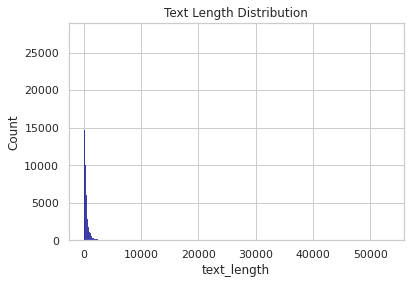

In [13]:

# Visualize a distribution of text_length
sns.histplot(data=train_df, x='text_length', bins='auto',color='darkblue');
plt.title('Text Length Distribution')

              precision    recall  f1-score        support
negative       0.908482  0.911465  0.909971  155012.000000
positive       0.911190  0.908199  0.909692  155042.000000
accuracy       0.909832  0.909832  0.909832       0.909832
macro avg      0.909836  0.909832  0.909832  310054.000000
weighted avg   0.909836  0.909832  0.909832  310054.000000


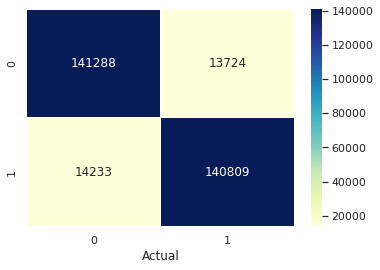

In [14]:
# Create a transformation pipeline
pipeline_log = Pipeline([
                ('count', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(solver='liblinear', multi_class='auto')),
        ])

# Train model using the created sklearn pipeline
model_name = 'logistic regression classifier'
model_lgr = pipeline_log.fit(train_df['text'], train_df['label'])

def evaluate_results(model, test_df):
    # Predict class labels using the learner function
    test_df['pred'] = model.predict(test_df['text'])
    y_true = test_df['label']
    y_pred = test_df['pred']
    target_names = ['negative','positive']

    # Print the Confusion Matrix
    results_log = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    results_df_log = pd.DataFrame(results_log).transpose()
    print(results_df_log)
    matrix = confusion_matrix(y_true,  y_pred)
    sns.heatmap(pd.DataFrame(matrix), 
                annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.xlabel('Predictions')
    plt.xlabel('Actual')
    
    model_score = score(y_pred, y_true, average='macro')
    return model_score

    
# Evaluate model performance
model_score = evaluate_results(model_lgr, test_df)
performance_df = pd.DataFrame().append({'model_name': model_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

              precision    recall  f1-score        support
negative       0.852549  0.894711  0.873122  155012.000000
positive       0.889256  0.845287  0.866714  155042.000000
accuracy       0.869997  0.869997  0.869997       0.869997
macro avg      0.870903  0.869999  0.869918  310054.000000
weighted avg   0.870904  0.869997  0.869918  310054.000000


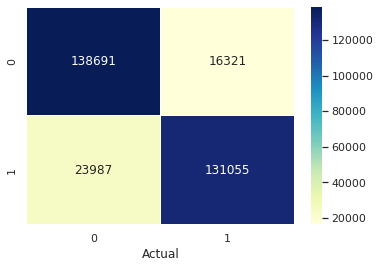

In [15]:
# Create a pipeline which transforms phrases into normalized feature vectors and uses a bayes estimator
model_name = 'bayes classifier'

pipeline_bayes = Pipeline([
                ('count', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('gnb', MultinomialNB()),
                ])

# Train model using the created sklearn pipeline
model_bayes = pipeline_bayes.fit(train_df['text'], train_df['label'])

# Evaluate model performance
model_score = evaluate_results(model_bayes, test_df)
performance_df = performance_df.append({'model_name': model_name, 
                                    'f1_score': model_score[0], 
                                    'precision': model_score[1], 
                                    'recall': model_score[2]}, ignore_index=True)

   f1_score                      model_name  precision    recall
0  0.909832  logistic regression classifier   0.909836  0.909832
1  0.869999                bayes classifier   0.870903  0.869918


Text(0.5, 1.0, 'Model Outlier Detection Performance (Macro)')

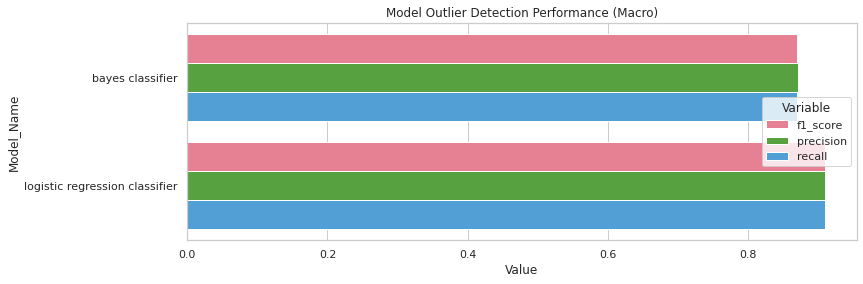

In [16]:
# Compare model performance
print(performance_df)

performance_df = performance_df.sort_values('model_name')
fig, ax = plt.subplots(figsize=(12, 4))
tidy = performance_df.melt(id_vars='model_name').rename(columns=str.title)
sns.barplot(y='Model_Name', x='Value', hue='Variable', data=tidy, ax=ax, palette='husl',  linewidth=1, edgecolor="w")
plt.title('Model Outlier Detection Performance (Macro)')

In [27]:
testphrases = ['Mondays just suck!', 'I love this product', 'Terrible service']
for testphrase in testphrases:
    resultx = model_lgr.predict([testphrase]) # use model_bayes for predictions with the other model
    print(testphrase + '-> ' + resultx[0])

Mondays just suck!-> negative
I love this product-> positive
Terrible service-> negative
